# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- Try and merge other currencies into USD columns? Might increase # stocks by a lot
- Need to try and fix some columns, like Revenue USD Mil
- Need to check out bad stocks that were strongly predicted to be good, there's many

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [2]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")

#tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
#tickers = tickers.loc[tickers['MarketCap']>1e6]  #exclude stocks with small market cap
tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


## Get Data

In [3]:
#small helper function for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS'), pd.date_range(date, periods=1, freq='BM')

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock,current_date):
    ds = current_date.split('-')
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    mean_current_price = DataReader(stock, 'yahoo', first_current, last_current)['Adj Close'].mean()
    mean_future_price = DataReader(stock, 'yahoo', first_future, last_future)['Adj Close'].mean()
    mean_past_price = DataReader(stock, 'yahoo', first_past, last_past)['Adj Close'].mean()
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price, mean_current_price
    
#simple progress bar
def progress_bar(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item

#scrape financial data from Morningstar
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK','OMR','AED']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    #delete annoying repeated columns
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #get indices
    i_current = np.where(d['index'].str.contains("%d"%year))[0][0]
    i_past = np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
    date_current = d['index'].iloc[i_current]
    #get data (values and YOY-ratios)
    values = pd.to_numeric(d.iloc[i_current], errors='coerce')
    YOY = values/pd.to_numeric(d.iloc[i_past], errors='coerce')
    YOY = YOY.add_suffix(' YOY')
    d = pd.DataFrame(pd.concat([values, YOY])).transpose()
    #get Fractional price changes (future/current -> for target and current/past -> for features)
    d['Stock'] = stock
    MFFPC, MPFPC, MP = get_mean_frac_price_change(stock,date_current)
    d['Mean Future Fractional Price Change'] = MFFPC
    d['Mean Past Fractional Price Change'] = MPFPC
    d['Mean Price'] = MP
    return d
        
#Top-level function which acquires all the data
def get_data(ticker_csv,year,true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_data.csv"%(ticker_loc,year))
        skip = np.loadtxt("%s_year%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        print "Loaded data from csv's..."
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        #create empty dataframe with available columns
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],year).columns
        X = pd.DataFrame(columns=cols)
        skip = []
        for s in progress_bar(stocks["Symbol"], len(stocks["Symbol"])/10):
            try:
                _X = get_stock_financials(s,year)
                if _X.shape[1] > 1: #only append if alg actually recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_data.csv"%(ticker_loc,year))
        np.savetxt("%s_year%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    #create target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change']>true_threshold)] = 1
    return X, y, skip

Load the data below. This could take a minute.

In [11]:
year = 2015
true_threshold=1.0  #Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
ticker_csv = "csv/wilshire5000.csv"
#ticker_csv = 'csv/nasdaq/Finance.csv'

X, y, skip = get_data(ticker_csv, year, true_threshold)

Loaded data from csv's...


In [12]:
#Relative class numbers
print "Number of True cases = %d"%len(y[y==1])
print "Number of False cases = %d"%len(y[y==0])

Number of True cases = 1667
Number of False cases = 771


## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [13]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            #X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "!couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

!couldnt convert Stock column to numeric. NaN fraction=0.0000
**Deleted** Accounts Payable: NaN fraction = 0.2063
**Deleted** Accounts Payable YOY: NaN fraction = 0.2170
Accounts Receivable: NaN fraction = 0.0648
Accounts Receivable YOY: NaN fraction = 0.0722
**Deleted** Accrued Liabilities: NaN fraction = 0.1669
**Deleted** Accrued Liabilities YOY: NaN fraction = 0.1756
Asset Turnover: NaN fraction = 0.0193
Asset Turnover (Average): NaN fraction = 0.0193
Asset Turnover (Average) YOY: NaN fraction = 0.0242
Asset Turnover YOY: NaN fraction = 0.0242
Book Value Per Share * USD: NaN fraction = 0.0074
Book Value Per Share * USD YOY: NaN fraction = 0.0111
**Deleted** COGS: NaN fraction = 0.2088
**Deleted** COGS YOY: NaN fraction = 0.2121
Cap Ex as a % of Sales: NaN fraction = 0.0496
Cap Ex as a % of Sales YOY: NaN fraction = 0.0611
**Deleted** Cap Spending USD Mil: NaN fraction = 0.1107
**Deleted** Cap Spending USD Mil YOY: NaN fraction = 0.1735
Cash & Short-Term Investments: NaN fraction = 

In [14]:
X.columns

Index([u'Stock', u'Accounts Receivable', u'Accounts Receivable YOY',
       u'Asset Turnover', u'Asset Turnover (Average)',
       u'Asset Turnover (Average) YOY', u'Asset Turnover YOY',
       u'Book Value Per Share * USD', u'Book Value Per Share * USD YOY',
       u'Cap Ex as a % of Sales', u'Cap Ex as a % of Sales YOY',
       u'Cash & Short-Term Investments', u'Cash & Short-Term Investments YOY',
       u'EBT Margin', u'EBT Margin YOY', u'Earnings Per Share USD',
       u'Earnings Per Share USD YOY', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Financial Leverage (Average) YOY',
       u'Financial Leverage YOY', u'Fixed Assets Turnover',
       u'Fixed Assets Turnover YOY', u'Free Cash Flow Per Share * USD',
       u'Free Cash Flow Per Share * USD YOY', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Net Income YOY', u'Free Cash Flow/Sales %',
       u'Free Cash Flow/Sales % YOY', u'Mean Future Fractional Price Change',
       u'Mean Past Fractional Price 

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [45]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
X['P/E Ratio'] = X['Mean Price']/X['Earnings Per Share USD']                 
X['P/B Ratio'] = X['Mean Price']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

X['Working Capital Ratio YOY'] = X['Total Assets YOY']/X['Total Liabilities YOY']   
X['P/E Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD YOY']                 
X['P/B Ratio YOY'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD YOY']
X['D/E Ratio YOY'] = X['Total Liabilities YOY']/X["Total Stockholders' Equity YOY"] 

columns = X.columns.tolist()
remove = ['Mean Future Fractional Price Change','Stock']
features = [x for x in columns if x not in remove]

#features to include for analysis
#percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %','Cap Ex as a % of Sales']
#ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD',
#          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Financial Leverage']
#other = ['Cash & Short-Term Investments','EBT Margin']
#features = ratios + percentiles + other

#Top features from analysis
#features = feat_imp[0:20].index

In [46]:
X[features].head()

,Accounts Receivable,Accounts Receivable YOY,Asset Turnover,Asset Turnover (Average),Asset Turnover (Average) YOY,Asset Turnover YOY,Book Value Per Share * USD,Book Value Per Share * USD YOY,Cap Ex as a % of Sales,Cap Ex as a % of Sales YOY,...,Total Stockholders' Equity,Total Stockholders' Equity YOY,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Working Capital Ratio YOY,P/E Ratio YOY,P/B Ratio YOY,D/E Ratio YOY
0,8.10,0.892070,0.44,0.44,0.676923,0.676923,12.36,0.734403,2.43,0.480237,...,55.72,1.139002,2.258356,29.630282,2.876726,0.794688,1.153568,1.268805,1.279754,0.761083
1,3.81,1.127219,0.53,0.53,1.019231,1.019231,5.05,1.018145,0.19,0.076613,...,32.58,0.991177,1.483239,25.086183,0.943837,2.069368,0.995699,1.238390,1.216320,1.013260
2,7.49,1.713959,1.24,1.24,0.976378,0.976378,18.50,1.116476,1.90,1.079545,...,51.40,1.032129,2.057613,12.284312,1.235071,0.945525,1.032922,0.466568,0.719705,0.937991
3,23.51,1.173739,1.54,1.54,0.968553,0.968553,3.74,1.129909,5.85,1.291391,...,76.84,1.029061,4.317789,27.888996,6.263839,0.301406,1.093696,1.055982,0.981301,0.888510
4,7.35,1.009615,1.21,1.21,0.828767,0.828767,32.94,1.248673,2.41,1.038793,...,30.25,1.202783,1.433692,23.773717,4.619059,2.305785,1.073118,1.016741,0.776639,0.774756


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [42]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [43]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.4507936507936508

In [44]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
n_iter = 15     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.1,0.5,1],
    'gamma': [0,0.2,0.4,0.8],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.718259557344
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 0.5, 'n_estimators': 1000, 'max_depth': 8, 'gamma': 0.2}


In [47]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 4
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[4000],
    'max_depth': [8],
    'min_child_weight': [0.1],
    'colsample_bytree': [0.5],
    'gamma': [0.2],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.713318801699


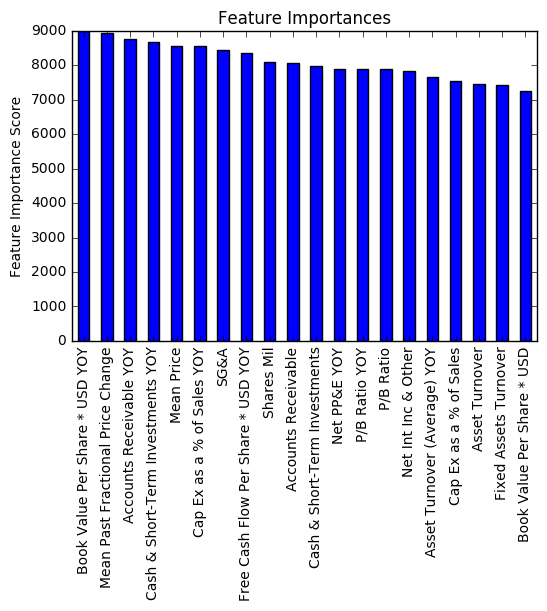

In [48]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

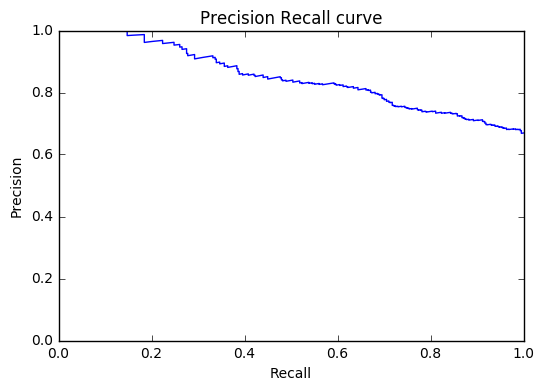

In [49]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

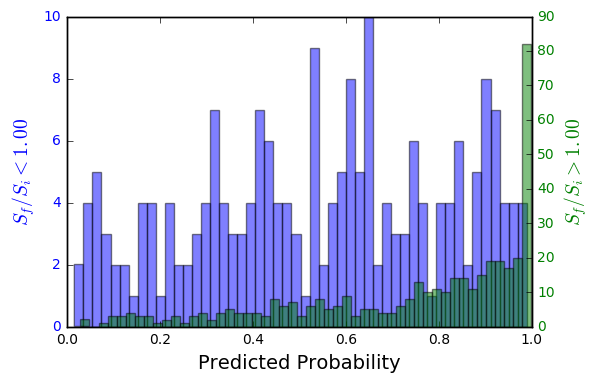

In [50]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.2f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.2f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Extra

In [25]:
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK','OMR','AED']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
#scrape/load data
d = pd.read_csv('%s%s_keyratios.csv'%(path, "A"), header=2, index_col=0, skiprows=skiprows)
d = d.transpose().reset_index()
i1 = np.where(d['index'].str.contains("%d"%2015))[0][0]
values = pd.to_numeric(d.iloc[i1], errors='coerce')
i2 = np.where(d['index'].str.contains("%d"%(2015-1)))[0][0]
ratios = values/pd.to_numeric(d.iloc[i2], errors='coerce')
ratios = ratios.add_suffix(' YOY')


,index YOY,Revenue USD Mil YOY,Gross Margin % YOY,Operating Income USD Mil YOY,Operating Margin % YOY,Net Income USD Mil YOY,Earnings Per Share USD YOY,Dividends USD YOY,Payout Ratio % * YOY,Shares Mil YOY,...,Financial Leverage,Debt/Equity,Days Sales Outstanding,Days Inventory,Payables Period,Cash Conversion Cycle,Receivables Turnover,Inventory Turnover,Fixed Assets Turnover,Asset Turnover
0,NaN,NaN,1.034836,1.245823,1.240385,0.730419,0.740741,0.754717,1.003968,0.991124,...,1.79,0.4,71.82,147.41,68.91,150.32,5.08,2.48,4.74,0.44


In [36]:
XX = X_test
XX['y_pred'] = y_pred[:,1]
XX['y_test'] = y_test
XX.head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Cap Ex as a % of Sales,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Financial Leverage,y_pred,y_test
1598,0.906746,1.037358,0.964687,1.008621,1.000561,0.817143,0.949461,0.956284,0.946903,0.993174,0.925408,1.451823,1.462255,1.221928,1.064516,1.131687,0.055927,0.0
620,1.653061,1.515385,1.414634,0.958333,0.036800,0.245747,1.130788,1.670732,-0.192090,1.153005,1.004233,2.401226,3.547796,0.971822,0.867470,0.975182,0.000460,0.0
1266,0.851986,0.775388,0.786227,0.511111,1.137579,1.073034,1.073663,0.827160,0.423729,0.518055,1.120737,0.921339,0.709808,0.873764,0.920635,0.975000,0.970860,1.0
649,0.158382,0.138399,0.119332,0.377483,0.096491,2.085470,0.968100,0.135484,0.681159,0.150738,0.930813,5.781380,0.809094,1.157813,0.750000,1.076142,0.964769,1.0
1908,1.050256,1.009162,1.029792,1.045161,0.901024,1.303922,1.057778,1.111111,0.893333,1.052733,1.109525,0.702828,0.738265,0.839412,0.983516,0.931429,0.980430,1.0


In [51]:
XX[(XX['y_test']==1) & (XX['y_pred']<0.3)].index

Int64Index([2033, 802, 2425, 25, 275], dtype='int64')

In [57]:
index = XX[(XX['y_test']==1) & (XX['y_pred']<0.4)].index
X["Book Value Per Share * USD"].iloc[index]

2033    0.874455
208     1.016921
2132    0.879365
163     0.317043
857     0.073529
802     0.024000
2229    0.952813
2425    0.855476
25      0.109589
283     0.406906
275     0.031536
1309    0.465116
1844    1.042789
Name: Book Value Per Share * USD, dtype: float64

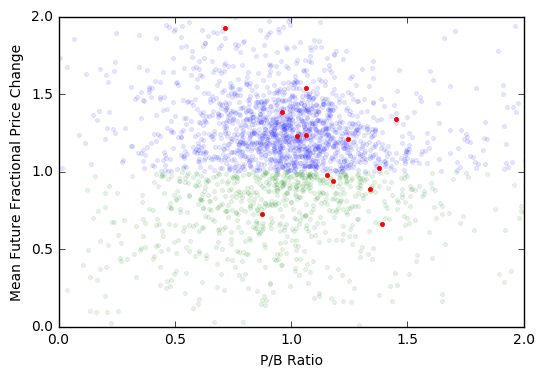

In [78]:
feature="P/B Ratio"
plt.plot(X.loc[y==1,feature], X.loc[y==1,"Mean Future Fractional Price Change"], '.', alpha=0.1)
plt.plot(X.loc[y==0,feature], X.loc[y==0,"Mean Future Fractional Price Change"], '.', alpha=0.1)

index = XX[(XX['y_test']==1) & (XX['y_pred']<0.4)].index
plt.plot(X[feature].iloc[index], X["Mean Future Fractional Price Change"].iloc[index], '.')
plt.ylim([0,2])
plt.xlim([0,2])
plt.xlabel(feature)
plt.ylabel("Mean Future Fractional Price Change")

Testing

In [ ]:
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
stock="A"
d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
d = d.transpose().reset_index()
#date = d['index'].values
#i1,i2 = np.where(d['index'].str.contains("%d"%year))[0][0], np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
#ratios = d.iloc[i1].convert_objects(convert_numeric=True)/d.iloc[i2].convert_objects(convert_numeric=True)
#d = pd.DataFrame(ratios).transpose()
#d.insert(0,'Stock',stock)                              #keep stock ticker
#d.insert(1,'Mean Fractional Price Change',get_mean_frac_price_change(stock,date)) #get fractional price change
l=pd.to_numeric(d.iloc[0], errors='coerce')/pd.to_numeric(d.iloc[1], errors='coerce')
l

In [ ]:
i1=np.where(d['index'].str.contains("%d"%year))[0][0]
date=d['index'].iloc[i1]
get_mean_frac_price_change("ABCB",date)

In [ ]:
plt.plot(X['Earnings Per Share USD'],X['Mean Fractional Price Change'], '.',alpha=0.05)
plt.xlim([-5,5])
plt.ylim([0,4])

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [ ]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [ ]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [ ]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [ ]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()